In [1]:
#**************************************** Importing constants*****************************************#

from constants import *

#*****************************************************************************************************#
#***************************************** Importing modules *****************************************#
#*****************************************************************************************************#

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import timeit
import kwant
from numpy import sin, exp, cos, pi, sqrt
import scipy.sparse.linalg as sla
import copy
import datetime

# data_dir = os.path.dirname(os.getcwd()) + '/data/'


C:\ProgramData\Miniconda3\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [2]:
#************************** Define a few helpful functions **************************#

from shapely.geometry import Point, Polygon

def parallelogram(v1, v2, trans = np.array([0,0]), return_coords = False):
    
    """ Create a parallelogram.
    
    Parameters:
    -----------
    v1, v2: Numpy arrays
        sides of the parallelogram
    trans: NumPy array
        position of the bottom left corner of the parallelogram
    return_coords: Bool
        if set to True the coordinates of the parallelogram are the second output
        
    Returns:
    --------
    poly: Shapely polygon
        Polygon of the parallelogram
    coords: NumPy array
        Optional output, coordinates of the vertices of the parallelogram
    """
    
    coords = np.array([trans, v1 + trans, v1 + v2 + trans, v2 + trans, trans])
    poly = Polygon(coords[:4])
    
    if return_coords:
        coords_new = [[],[]]
        for i in range(len(coords)):
            coords_new[0].append(coords[i][0])
            coords_new[1].append(coords[i][1])
        return poly, coords_new
    else:
        return poly
    
        
def rotate(v,theta):

    '''
        Rotate a vector in 3D ( NumPy array or list) by an angle theta (in radians) along the z-axis
    '''

    Rmatrix = np.array([[cos(theta), -sin(theta), 0.],
                        [sin(theta),  cos(theta), 0.],
                        [0.        ,          0., 1.]])
    
    return Rmatrix @ v


def plot_layer(layer_sites, mUC_coords = []):
    
    """ Plot a single layer of graphene.
    
    Parameters:
    -----------
    layer_sites: List
        Kwant sites that make one unit cell of the crystal
    mUC_coords: List
        coordinates of the unit cell in reciprocal space
        
    Returns: None

    """

    xs = []
    ys = []
    
    for i in range(len(layer_sites)):
        xs.append(layer_sites[i].pos[0])
        ys.append(layer_sites[i].pos[1])
    
    plt.figure(figsize=(10,10))
    plt.scatter(xs,ys,s=10,c='k')
    
    if len(mUC_coords) > 0:
        plt.plot(mUC_coords[0], mUC_coords[1],c='r') 
        
    boundary = max(max(xs), max(ys))
        
    plt.xlim(-5,1.2 * boundary + 1)
    plt.ylim(-5,1.2 * boundary + 1) 
    plt.show()
    plt.close()
    
#************************************************ Main function ************************************************#


def create_lattice(theta = 7.34, stacking = 'AA', plot_layers = True, timer = True): 
    
    '''
        Generate two lists of kwant site objects containing the nodes in one moire Unit Cell (mUC). 
            - Use plot_layers for visual confimation that the lattice is fully periodic (for commensurate angles)
            - The stacking should be AA or AB (no error raised if it is otherwise, it will default to AA)
        
    '''
    
    """ Generate the list of sites of one moire unit cell.
    
    Parameters:
    -----------
    theta: float
        twist angle in degrees
    stacking: 'AA' or 'AB'
        stacking of bilayer graphene at zero twisting
    plot_layers: bool
    timer: bool
        
    Returns:
    --------
    bot_sites, top_sites: lists

    """
    
    start = timeit.default_timer()
    theta = np.radians(theta)
    global Lm, V1, V2 # These costants are necessary in outer functions, so I made them global.
    
    # Creating the two lattices for the layers
    
    Lm = a0 / (2 * sin(theta / 2)) # Honeycomb lattice constant of mUC [A]
    V1 = Lm * np.array([cos_30, sin_30, 0]) # Primitive vectors of mUC [A]
    V2 = Lm * np.array([0,1, 0 ])
    
    a1 = a0 * np.array([sin_30,cos_30,0]) # Primitive vectors of unrotated graphene
    a2 = a0 * np.array([1,0,0])

    a1_top = rotate(a1,theta / 2) # Primitive vectors top layer
    a2_top = rotate(a2,theta / 2)

    a1_bot = rotate(a1,-theta / 2) # Primitive vectors bottom layer    
    a2_bot = rotate(a2,-theta / 2)

    basis_top1 = np.array([0,0,d0]) # Basis vectors top layer
    basis_top2 = rotate(np.array( [0, lcon,d0]),theta / 2)

    if stacking == 'AB':
        basis_top1 += np.array([lcon*sin_30,lcon*cos_30,0])
        basis_top2 += np.array([lcon*sin_30,lcon*cos_30,0])
        
    basis_bot1 = np.array([0,0,0]) # Basis vectors bottom layer
    basis_bot2 = rotate(np.array( [0, lcon,0]), -theta / 2)

    top_layer = kwant.lattice.general([a1_top, a2_top],
                                     [basis_top1, basis_top2],
                                     norbs=1)

    bot_layer = kwant.lattice.general([a1_bot, a2_bot],
                                     [basis_bot1, basis_bot2],
                                     norbs=1)

    ab, bb = bot_layer.sublattices
    at, bt = top_layer.sublattices

    syst = kwant.Builder()
    
    # Create the moire unit cell
    poly, coords = parallelogram(V1[0:2],V2[0:2],trans = np.array([0,0]), return_coords = True)
    
    eps = 0.2 
    def is_inside_polygon(pos): # We include all sides inside or at a small distance of the mUC, latter we will delete repeated sites
        x,y,z = pos
        pt = Point([x,y])
        return pt.within(poly) or pt.distance(poly) < eps
    
    # Adding all sites inside the mUC

    syst[bot_layer.shape(is_inside_polygon, (ab(3,0).pos[0], ab(3,0).pos[1], 0))] = 0
    bot_sites = list(syst.sites())

    syst[top_layer.shape(is_inside_polygon, (at(3,0).pos[0], at(3,0).pos[1], 0))] = 0
    top_sites = list(syst.sites())[len(bot_sites):] 
    
    # Making polygons at the boundaries (for the hoppings between the unit cells)
    
    poly_left = parallelogram(V1[0:2] * 5 / Lm,V2[0:2],trans = np.array([0,0]))
    poly_right = parallelogram(V1[0:2] * 5 / Lm,V2[0:2],trans = V1[0:2] * (1 - 5 / Lm))
    poly_bot = parallelogram( V1[0:2] , V2[0:2] * 5 / Lm,trans = np.array([0,0]))
    poly_top = parallelogram( V1[0:2] , V2[0:2] * 5 / Lm,trans = V2[0:2] * (1 - 5 / Lm))

    bot_sites_left, bot_sites_right, bot_sites_bot, bot_sites_top = [],[],[],[]
    top_sites_left, top_sites_right, top_sites_bot, top_sites_top = [],[],[],[]
    
    # Adding the sites in the boundary polygons
    
    for i,site in enumerate(bot_sites):
        x,y,z = site.pos
        pt = Point([x,y])
        if pt.within(poly_left) or pt.distance(poly_left) < eps:
            bot_sites_left.append(site)
        if pt.within(poly_right) or pt.distance(poly_right) < eps:
            bot_sites_right.append(site)
        if pt.within(poly_bot) or pt.distance(poly_bot) < eps:
            bot_sites_bot.append(site)
        if pt.within(poly_top) or pt.distance(poly_top) < eps:
            bot_sites_top.append(site)
            
    for i,site in enumerate(top_sites):
        x,y,z = site.pos
        pt = Point([x,y])
        if pt.within(poly_left) or pt.distance(poly_left) < eps:
            top_sites_left.append(site)
        if pt.within(poly_right) or pt.distance(poly_right) < eps:
            top_sites_right.append(site)
        if pt.within(poly_bot) or pt.distance(poly_bot) < eps:
            top_sites_bot.append(site)
        if pt.within(poly_top) or pt.distance(poly_top) < eps:
            top_sites_top.append(site)
            
    def distance_arrays(pos1, pos2):
        '''
            Calculate the distance between two NumPy arrays in 3D
        '''
        x1,y1,z1 = pos1
        x2,y2,z2 = pos2
        sq = (x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2
        return sqrt(sq)
    
    # Eliminating stacked sites
    
    for translated_bot_sites in [bot_sites_left, bot_sites_bot]:
        for non_translated_bot_sites in [bot_sites_right, bot_sites_top]:
            for site1 in non_translated_bot_sites:
                for site2 in translated_bot_sites:
                    for translation in [V1, V2, V1 + V2, V1 - V2]:
                        dist = distance_arrays(site1.pos, site2.pos + translation)
                        if dist < 0.1:
                            try: 
                                bot_sites.remove(site1)
                            except: # If twice stacked this would raise an error, as it deleted the site already
                                None 
                                
    for translated_top_sites in [top_sites_left, top_sites_bot]:
        for non_translated_top_sites in [top_sites_right, top_sites_top]:
            for site1 in non_translated_top_sites:
                for site2 in translated_top_sites:
                    for translation in [V1, V2, V1 + V2, V1 - V2]:
                        dist = distance_arrays(site1.pos, site2.pos + translation)
                        if dist < 0.1:
                            try: 
                                top_sites.remove(site1)
                            except: # If twice stacked this would raise an error, as it deleted the site already
                                None 

    # Plotting
    
    if plot_layers:
        
        plot_layer(bot_sites, mUC_coords = coords)
        plot_layer(top_sites, mUC_coords = coords)
    
    # Printing out timer
    
    if timer:
        
        print('Creating the lattice took: {:.2f}s'.format(timeit.default_timer() - start))
               
    return bot_sites, top_sites

## Step 2: Extracting the Hamiltonian

In [3]:
#***************************************** Helpful secondary functions *****************************************#

def quick_plot(syst): # Makes a quick plot of a kwant.Builder object    
    
    '''
        Show a quick plot of a kwant system (Kwant.Builder) object
    '''
    
    azim, dist, elev = -90, 10, 90 # Default: -60, 10, 30, View from above: -90, 10, 90
    fig = plt.figure(figsize=(15,15))
    ax = fig.gca(projection='3d')
    ax.azim = azim
    ax.dist = dist
    ax.elev = elev             
        
    def site_color(site):
        '''
            Set the color of the nodes (black or white in the graphene sublattices)
        '''
        x,y,z = site.pos
        if z > 0.1:
            return 'black'
        else:
            return 'white'
        
    kwant.plot(syst,site_size = 0.25 ,site_color = site_color,hop_lw = 0.1,ax = ax, num_lead_cells = 4);
    plt.show()
    plt.close()
    
def distance_sites(site1, site2):
    
    '''
        Returns the distance between two kwant site objects
    '''
    
    x1,y1,z1 = site1.pos
    x2,y2,z2 = site2.pos
    sq = (x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2
    
    return sqrt(sq)
    
def interlayer_hopping(dist): 
    
    '''
        Returns the interlayer hopping given the distanc between using the minimal model (exponential decay)
    '''
    
    ex = exp( - ( dist - d0 ) / lambda0)
    
    return Vpps * ex * d0 * d0 / (dist ** 2)

def get_commensurate_angles(q = 1, N = 1, print_angles = True):
    '''
        Returns N commensurate angles (in degrees) of TBG, from highest to lowest                         
    '''
    
    angles = []
    for p in range(N):
        p += 1
        num = 3*p*p + 3*p*q + q*q/2
        denom = 3*p*p + 3*p*q + q*q
        angles.append(np.degrees(np.arccos(num / denom)))
    if print_angles:
        for angle in angles:
            print(angle, end = ', ')
    return(angles)
            

#************************************************ Main function ************************************************#

def generate_hamiltonian(bot_sites, top_sites, Nx = 1, Ny = 1, cutoff = 5, timer = True):
    
    '''
        Returns a function that generates the sparse matrix for a given pseudomomentum (kx, ky). It takes the list of sites in the
        top and bottom layers.
            - Nx and Ny are the number of subcells to be generated (to drastically reduce the number of interlayer hoppings). Testing showed
              that Nx(Ny) approx Lm / 5 is a good choice.
            - cutoff determines the distance at which the subcells will have interlayer hoppings between them: 5 is very good 
              though it can be lowered and it still reproduces the results with negligible error.
    '''
    
    start = timeit.default_timer()
    bot_pos = [bot_sites[i].pos for i in range(len(bot_sites))]
    top_pos = [top_sites[i].pos for i in range(len(top_sites))]
    
    bot_lat = kwant.lattice.general([V1,V2], bot_pos)
    top_lat = kwant.lattice.general([V1,V2], top_pos)
    
    bot_sublats = bot_lat.sublattices
    top_sublats = top_lat.sublattices
    syst = kwant.Builder(kwant.TranslationalSymmetry(V1,V2))
    
    for i in range(len(bot_pos)):
        syst[bot_sublats[i](0,0)] = -chem_pot
        
    for i in range(len(top_pos)):
        syst[top_sublats[i](0,0)] = -chem_pot

    V1p = V1[0:2] / Nx
    V2p = V2[0:2] / Ny
    
    polygons = []
    site_domains_bot = []
    site_domains_top = []
    sites = list(syst.sites())
    
    for nx in range(Nx):
        vector_polygon_temp = []
        site_domain_bot = []
        site_domain_top = []
        for ny in range(Ny):
            sites_bot_temp = []
            sites_top_temp = []
            trans_temp =  V1p * nx + V2p * ny - (cutoff / 2) * np.array([cos_30, sin_30 + 1])
            poly_temp, coords = parallelogram(V1p + cutoff * np.array([cos_30, sin_30]),\
                                              V2p + cutoff * np.array([0,1]) ,\
                                              trans = trans_temp, return_coords = True)
            vector_polygon_temp.append(poly_temp)
            for site in sites:
                x,y,z = site.pos
                pt = Point([x,y])
                if pt.within(poly_temp):
                    if z == 0:
                        sites_bot_temp.append(site)
                    else:
                        sites_top_temp.append(site)

            site_domain_bot.append(sites_bot_temp)
            site_domain_top.append(sites_top_temp)
    
        polygons.append(vector_polygon_temp)
        site_domains_bot.append(site_domain_bot)
        site_domains_top.append(site_domain_top)
    
    if timer:
        print('Creating the system and dividing it into subdomains took {:.2f}s'.format(timeit.default_timer() - start))
    
    start = timeit.default_timer()
        
    # Intralayer hoppings within the unit cell

    for nx in range(Nx):
        for ny in range(Ny):
            for site1 in site_domains_bot[nx][ny]:
                for site2 in site_domains_bot[nx][ny]:
                    dist = distance_sites(site1,site2)
                    if np.isclose(lcon, dist,atol=0.001):
                        syst[site1, site2] = -Vppp
            for site1 in site_domains_top[nx][ny]:
                for site2 in site_domains_top[nx][ny]:
                    dist = distance_sites(site1,site2)
                    if np.isclose(lcon, dist,atol=0.001):
                        syst[site1, site2] = -Vppp
                        
                        
    # Intralayer hoppins at the boundaries
    
    for nx in range(Nx):
        for site_domains in [site_domains_bot, site_domains_top]:
            for site1 in site_domains[nx][0]:
                for site2 in site_domains[nx][Ny-1]:
                    site1_sublat = site1.family
                    site2_sublat = site2.family
                    dist = distance_sites(site1_sublat(0,0), site2_sublat(0,-1))
                    if np.isclose(lcon, dist,atol=0.01):
                        syst[kwant.builder.HoppingKind((0,-1), site2_sublat, site1_sublat)] = - Vppp

                
    for ny in range(Ny):
        for site_domains in [site_domains_bot, site_domains_top]:
            for site1 in site_domains[0][ny]:
                for site2 in site_domains[Nx-1][ny]:
                    site1_sublat = site1.family
                    site2_sublat = site2.family
                    dist = distance_sites(site1_sublat(0,0), site2_sublat(-1,0))
                    if np.isclose(lcon, dist,atol=0.01):
                        syst[kwant.builder.HoppingKind((-1,0), site2_sublat, site1_sublat)] = - Vppp
                        
    if timer:
        print('Adding the intralayer hoppings took {:.2f}s'.format(timeit.default_timer() - start))
        
    start = timeit.default_timer()
        
    # Interlayer hoppings within the unit cell
    
    for nx in range(Nx):
        for ny in range(Ny):
            for site1 in site_domains_bot[nx][ny]:
                for site2 in site_domains_top[nx][ny]:
                    dist = distance_sites(site1,site2)
                    syst[site1,site2] = -interlayer_hopping(dist)
                    
    #Interlayer hoppings at the boundaries
                    
    for nx in range(Nx):
        for site1 in site_domains_bot[nx][0]:
            for site2 in site_domains_top[nx][Ny-1]:
                site1_sublat = site1.family
                site2_sublat = site2.family
                dist = distance_sites(site1_sublat(0,0), site2_sublat(0,-1))
                syst[kwant.builder.HoppingKind((0,-1), site2_sublat, site1_sublat)] = - interlayer_hopping(dist)
        for site1 in site_domains_top[nx][0]:
            for site2 in site_domains_bot[nx][Ny-1]:
                site1_sublat = site1.family
                site2_sublat = site2.family
                dist = distance_sites(site1_sublat(0,0), site2_sublat(0,-1))
                syst[kwant.builder.HoppingKind((0,-1), site2_sublat, site1_sublat)] = - interlayer_hopping(dist)
                
    for ny in range(Ny):
        for site1 in site_domains_bot[0][ny]:
            for site2 in site_domains_top[Nx-1][ny]:
                site1_sublat = site1.family
                site2_sublat = site2.family
                dist = distance_sites(site1_sublat(0,0), site2_sublat(-1,0))
                syst[kwant.builder.HoppingKind((-1,0), site2_sublat, site1_sublat)] = - interlayer_hopping(dist)
        for site1 in site_domains_top[0][ny]:
            for site2 in site_domains_bot[Nx-1][ny]:
                site1_sublat = site1.family
                site2_sublat = site2.family
                dist = distance_sites(site1_sublat(0,0), site2_sublat(-1,0))
                syst[kwant.builder.HoppingKind((-1,0), site2_sublat, site1_sublat)] = - interlayer_hopping(dist)
                
    for site1 in site_domains_bot[0][0]:
        for site2 in site_domains_top[Nx-1][Ny-1]:
            site1_sublat = site1.family
            site2_sublat = site2.family
            dist = distance_sites(site1_sublat(0,0), site2_sublat(-1,-1))
            syst[kwant.builder.HoppingKind((-1,-1), site2_sublat, site1_sublat)] = - interlayer_hopping(dist)
            
    for site1 in site_domains_top[0][0]:
        for site2 in site_domains_bot[Nx-1][Ny-1]:
            site1_sublat = site1.family
            site2_sublat = site2.family
            dist = distance_sites(site1_sublat(0,0), site2_sublat(-1,-1))
            syst[kwant.builder.HoppingKind((-1,-1), site2_sublat, site1_sublat)] = - interlayer_hopping(dist)
            
    for site1 in site_domains_bot[Nx-1][0]:
        for site2 in site_domains_top[0][Ny-1]:
            site1_sublat = site1.family
            site2_sublat = site2.family
            dist = distance_sites(site1_sublat(0,0), site2_sublat(1,-1))
            syst[kwant.builder.HoppingKind((1,-1), site2_sublat, site1_sublat)] = - interlayer_hopping(dist)
            
    for site1 in site_domains_top[Nx-1][0]:
        for site2 in site_domains_bot[0][Ny-1]:
            site1_sublat = site1.family
            site2_sublat = site2.family
            dist = distance_sites(site1_sublat(0,0), site2_sublat(1,-1))
            syst[kwant.builder.HoppingKind((1,-1), site2_sublat, site1_sublat)] = - interlayer_hopping(dist)
        
    if timer:
        print('Adding the interlayer hoppings took {:.2f}s'.format(timeit.default_timer() - start))
    
    start = timeit.default_timer()
    
    syst_wrap = kwant.wraparound.wraparound(syst,coordinate_names=('x','y'))
    systf = syst_wrap.finalized()
    Ham = lambda kx,ky: systf.hamiltonian_submatrix(params=dict(k_x=kx,k_y=ky), sparse = True)

    if timer:
        print('Wrapping up the system took {:.2f}s'.format(timeit.default_timer() - start))
    
    return Ham

## Step 3: Creating the surface of integration

In [4]:
def get_area(k_lim_coords = None, Nx = 100, Ny = 100, plot_area = False):
    
    '''
        Returns the matrices X, Y, X_converted and Y_converted which are the meshgrids which contain the pseudomomenta in 
        the mBZ. Recall that kwant does not make the system orthogonal so we need to make a linear transformation of X, Y
        before giving them as input to the function Ham. 
            - k_lim_coords is a list or NumpyArray that has the coordinates of the box in which X and Y are contained.
              If it is None the function will take the whole mBZ instead. 
            - Nx, Ny are the number of points in which the area is divided
    '''
    
    if k_lim_coords is None and (Nx % 4 != 0 or Ny % 4):
        
        raise ValueError("Warning! For the full mBZ both Nx and Ny should be divisible by 4! The code reduces the computation time by " + 
                         "taking only a fourth of the area and using the system's symmetry!")
                         
    
    k_D = 2 * np.pi / np.sqrt(3)
    
    if k_lim_coords is None:
        k_lim_coords = [[- k_D, k_D],[- k_D, k_D]]

    kx_range = np.linspace(k_lim_coords[0][0], k_lim_coords[0][1], Nx)
    ky_range = np.linspace(k_lim_coords[1][0], k_lim_coords[1][1], Ny)
        
    rad_30 = np.radians(30)
    X, Y = np.meshgrid(kx_range,ky_range, indexing = 'ij')
    X_converted, Y_converted = np.zeros(X.shape), np.zeros(Y.shape)
    
    for i in range(Nx):
        for j in range(Ny):
            
            X_converted[i,j] = X[i,j] + Y[i,j] * (np.sin(rad_30) / np.cos(rad_30))
            Y_converted[i,j] = Y[i,j] / np.cos(rad_30)
    
            
    if plot_area:

        Gamma = np.array([0,0])
        K_D = k_D * np.array([cos_30,sin_30])
        K_Dp = k_D * np.array([cos_30,-sin_30])
        M = k_D * np.array([cos_30,0])
        mBZ_coordinates = [K_D, K_Dp, np.array([0,-k_D]), -K_D, -K_Dp, np.array([0,k_D]), K_D]
        
        plt.figure(figsize = (6,6))
        plt.xlim(-k_D * 1.1,k_D * 1.1)
        plt.ylim(-k_D * 1.1,k_D * 1.1)
        
        for i in range(len(mBZ_coordinates) - 1):    
            plt.plot([mBZ_coordinates[i][0],mBZ_coordinates[i+1][0]],[mBZ_coordinates[i][1],mBZ_coordinates[i+1][1]],'r--')
        
        
        for indeces in [(0,1,0,0),(1,1,0,1),(1,0,1,1),(0,0,1,0)]:
            a,b,c,d = indeces
            plt.plot([k_lim_coords[0][a],k_lim_coords[0][b]],[k_lim_coords[1][c],k_lim_coords[1][d]],'b--')
            
            
    return X, Y, X_converted, Y_converted

## Diagonalizing the Hamiltonian

In [5]:
def estimate_diagonalization_time(Ham, X, Y, full_mBZ = True, Nen = 16, sigma = 0, tol = 1e-4):
    
    '''
        Diagonalizes the Hamiltonian in one point and estimates the total runtime
    '''
    
    N = len(X) * len(X[0])
    
    if full_mBZ:
        N = N / 4 
        
    start = timeit.default_timer()
    
    np.sort(sla.eigsh(Ham(0,0), k = Nen, sigma=sigma, return_eigenvectors=False, which='LM',tol=tol))
    
    time = timeit.default_timer() - start
    time1 = str(datetime.timedelta(seconds = time))
    time2 = str(datetime.timedelta(seconds = time * N))
    
    print('Diagonalizing one matrix takes: {}; estimated runtime: {}'.format(time1, time2))
    

def diagonalize_matrices(Ham, X, Y, X_converted, Y_converted, full_mBZ  = True, Nen = 16, sigma = 0, tol =1e-4, timer = True):
    
    '''
        Diagonalize the Hamiltonian through the area indicated with matrices X, Y (and their converted counterparts)
    '''
    
    start = timeit.default_timer()
    Nx = len(X)
    Ny = len(X[0])
    E = np.zeros((Ny,Nx,Nen))
    
    if full_mBZ:   
        for i in range(int(Nx / 2)):   
            for j in range(int(Ny / 2)):

                temp = np.sort(sla.eigsh(Ham(X_converted[i,j],Y_converted[i,j]), k = Nen, sigma=sigma,
                                         return_eigenvectors=False, which='LM',tol=tol))

                E[j,i,:] = temp
                E[Nx - j - 1,i,:] = temp
                E[j, Ny - i - 1,:] = temp
                E[Nx - j - 1, Ny - i - 1,:] = temp    
    else:
        for i in range(Nx):   
            for j in range(Ny):
                
                temp = np.sort(sla.eigsh(Ham(X_converted[i,j],Y_converted[i,j]), k = Nen, sigma=sigma,
                                         return_eigenvectors=False, which='LM',tol=tol))

                E[i,j,:] = temp
    if timer:
        print('Diagonalizing the matrices took: {}'.format(str(datetime.timedelta(seconds = int(timeit.default_timer() - start)))))
        
    return E

## Extracting the flat bands from the energy matrix 

In [6]:
#******** This method works only if the flat bands, and no other bands, are in the range (E_min, E_max) ********#

def get_flat_bands(E, E_min, E_max):
    
    E_flat = np.zeros((np.shape(E)[0], np.shape(E)[1], 4))
    error_counter = 0
    
    for i in range(np.shape(E)[0]): 
        
        for j in range(np.shape(E)[1]):
            
            counter = 0
            
            for en in range(np.shape(E)[2]):
        
                if E_min < E[i,j,en] <  E_max:      
                
                    try:
                        E_flat[i,j,counter] = E[i,j,en]
                        
                    except IndexError:   
                        error_counter += 1
                        print("Warning, more than 4 bands were found within the range indicated!")
                        break
                        
                    counter += 1
                        

            E_flat[i,j,:] = np.sort(E_flat[i,j,:])
            
    if error_counter > 0:
        
        print('There were {} places in which more than 4 bands were found!'.format(error_counter))
        
    return E_flat
            

In [7]:
angles = get_commensurate_angles(N = 40, print_angles = True)

21.78678929826181, 13.173551107258918, 9.430007907896421, 7.340993016630217, 6.008983197766148, 5.085847808123473, 4.408455007944072, 3.8902381690076835, 3.481006089466939, 3.149657426389616, 2.875894633632971, 2.6459083811926885, 2.4499772766168695, 2.2810596097298803, 2.1339296665972505, 2.004627830691014, 1.8900990734694358, 1.787948610382325, 1.6962726935197672, 1.6135389011625705, 1.538499818371707, 1.4701297257779093, 1.4075774463457396, 1.350130735571569, 1.2971890475935015, 1.2482424655263473, 1.202855227481003, 1.1606527198522039, 1.1213111153817366, 1.0845490491576433, 1.0501208797943464, 1.0178111944464099, 0.9874302978136178, 0.9588104855247125, 0.9318029472641524, 0.9062751788952574, 0.8821088085785386, 0.8591977616312254, 0.8374467041002995, 0.8167697168934015, 

Twist angle: 7.340993016630217
Creating the lattice took: 0.17s
Creating the system and dividing it into subdomains took 0.35s
Adding the intralayer hoppings took 0.73s
Adding the interlayer hoppings took 1.27s
Wrapping up the system took 0.99s
Diagonalizing one matrix takes: 0:00:00.083535; estimated runtime: 0:00:33.414080
Diagonalizing the matrices took: 0:00:32


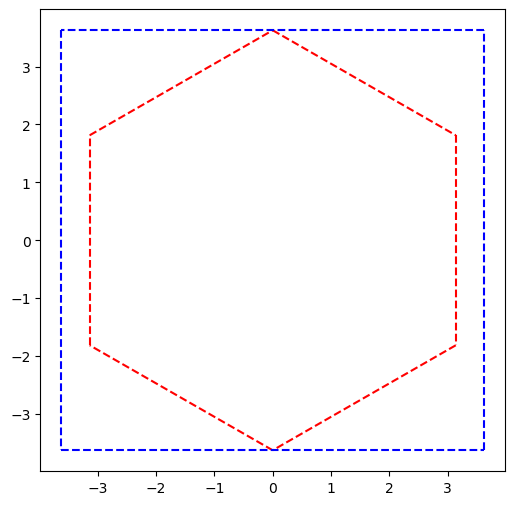

In [8]:
#************************************** Getting a commensurate twist angle **************************************#

theta = 7.340993016630217
print('Twist angle: ' + str(theta))

#************************************ Getting the grid of points in the mBZ ************************************#

k_D = 2 * np.pi / np.sqrt(3)
k_lim_coords = None
X, Y, X_converted, Y_converted = get_area(k_lim_coords = k_lim_coords, Nx = 40, Ny = 40, plot_area = True)

#*********************************** Obtaining the lists of sites in the mBZ ***********************************#

bot_sites, top_sites = create_lattice(theta = theta, plot_layers = False)

#****************************************** Generating the Hamiltonian ******************************************#

Ham = generate_hamiltonian(bot_sites, top_sites, Nx = int(Lm / 5), Ny = int(Lm / 5))

#************************************** Diagonalizing the sparse matrices **************************************#

estimate_diagonalization_time(Ham, X = X, Y = Y, full_mBZ = True, Nen = 16, sigma = 0., tol = 1e-4)
E = diagonalize_matrices(Ham, X, Y, X_converted, Y_converted, full_mBZ  = True, Nen = 16, sigma = 0., tol = 1e-4)

In [9]:
def get_DOS(E, dE, E_range, timer = True):
    
    """
        Returns the list of energy values in the range E_range and the number of states within dE / 2 of them
    """
    
    start_timer = timeit.default_timer()
    N_states = []
    energies_dos = []
    E_min, E_max = E_range
    
    for n in range(int((E_max - E_min) / dE)):
        
        energy = E_min + n * dE
        N_states_counter = 0
        
        for i in range(np.shape(E)[0]):
            for j in range(np.shape(E)[1]):
                for k in range(np.shape(E)[2]):
                    
                    if energy - dE / 2 < E[i,j,k] < energy + dE / 2:
                        N_states_counter += 1
        
        energies_dos.append(energy)
        N_states.append(N_states_counter)
        
    if timer:
        print('Extracting the DOS took: {}'.format(str(datetime.timedelta(seconds = int(timeit.default_timer() - start_timer)))))
        
    return energies_dos, N_states


def plot_DOS(energies_dos, N_states, dE = None, peaks_indexes = None, xlim = None, return_peak_values = False):
    
    """
        Plots the Density of States given the lists of energy values and number of states.
            - If peaks_indexes is given (a list of integers withing the length of the input lists) it plots also their position in the plot.
              This is in order to locate the energy values at the peaks (singularities).
            - If peaks_indexes is given and return_peak_values is True it returns a list with the energy values at the peaks selected
    """
    
    
    plt.rcParams.update({'font.size': 20})
    fig,ax1 = plt.subplots(figsize = (16,10))
    
    if dE is not None:
        ax1.plot(energies_dos, N_states, marker = 'o', color = 'blue', label = r"dE = {} eV".format(dE), markersize=6)
        ax1.legend(loc = (0.40,0.80),fontsize = 18)
    else:
        ax1.plot(energies_dos, N_states, color = 'blue', markersize=6)

    ax1.set_xlabel("Energy [eV]")
    ax1.set_ylabel("Number of states")
    
    if xlim is not None:
        ax1.set_xlim(xlim[0],xlim[1])
    
    if peaks_indexes is not None:
        
        peak_values = []
        for index in peaks_indexes:
            
            peak_values.append(energies_dos[index])
            ax1.vlines([energies_dos[index]], ymin = 0, ymax = max(N_states),ls ='dashed',lw = 0.5, color = 'r')
                        
    plt.title("TBG DOS (theta = {:.2f}, Vpps = {:.3f})".format(theta, Vpps));

    plt.show()
    plt.close()
    
    if return_peak_values:
        
        return [energies_dos[index] for index in peaks_indexes]

In [10]:
E_range = (-2,2)
dE = 5e-2
energies_dos, N_states = get_DOS(E, dE, E_range, timer = True)

Extracting the DOS took: 0:00:00


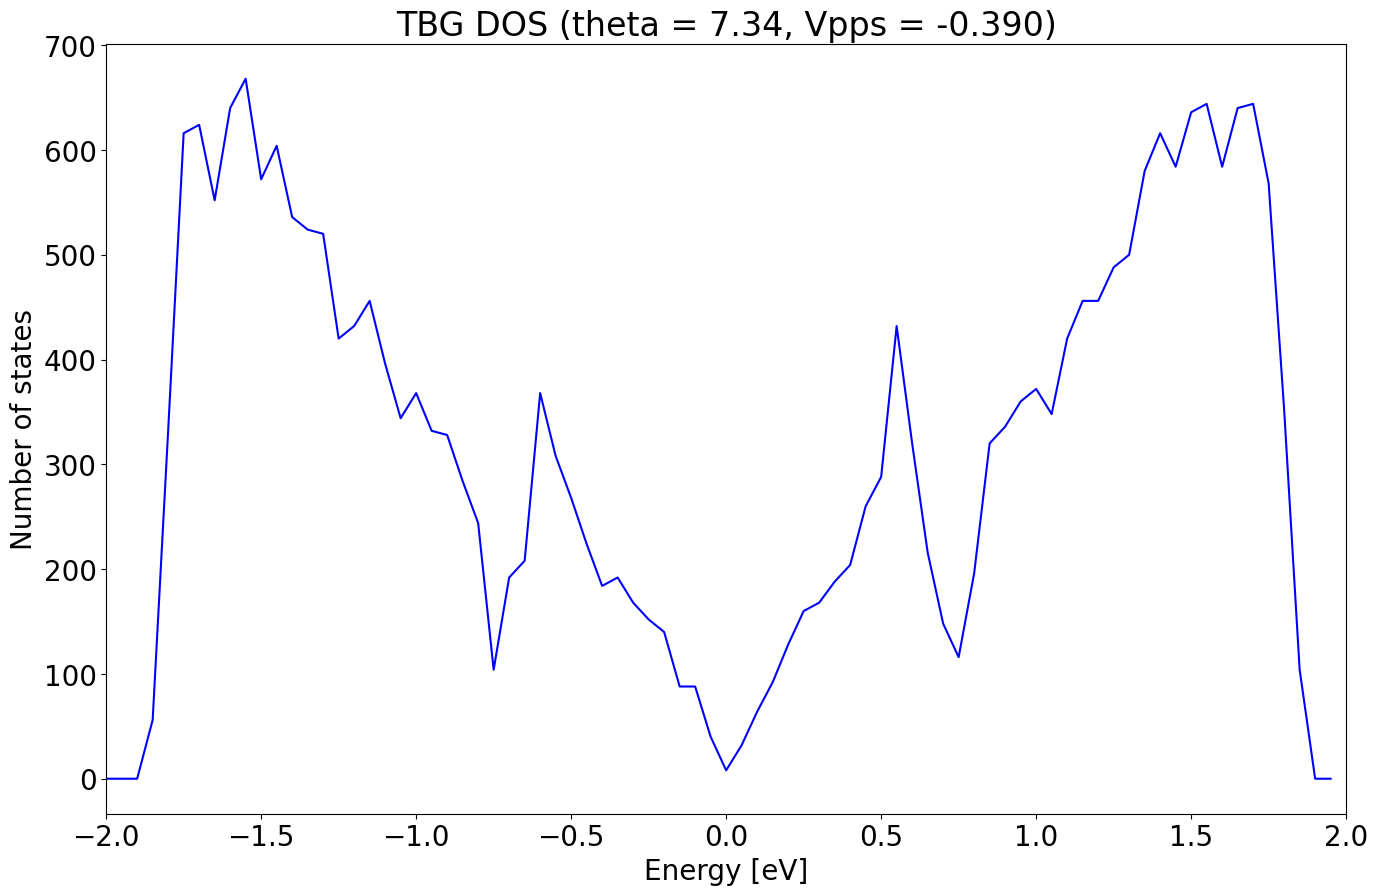

In [11]:

plot_DOS(energies_dos, N_states, peaks_indexes = None, xlim = E_range, return_peak_values = False)